In [97]:
import numpy as np, string, utils, preprocess
import nltk
import graph

%reload_ext autoreload
%autoreload 2

In [ ]:
quran = utils.load_text("books/quran-shakir.txt")
print(quran[:103])

In [98]:
nlinks = 4

quran_occs, words_map = preprocess.text_to_graph(quran, ignore_stopwords=True, self_links=False, nlinks=1, return_words_map=True, max_weight=np.power(2, nlinks))
print("Sparsity: {:05.2f}%".format(100 * (1 - np.count_nonzero(quran_graph) / quran_graph.size)))

Sparsity: 00.03%


In [128]:
max_occs = np.amax(quran_occs)
quran_graph = -(quran_occs**2) + max_occs**2

kernel_width = quran_graph.mean()
weights = np.exp(-quran_graph**2 / kernel_width**2)
np.fill_diagonal(weights, 0)

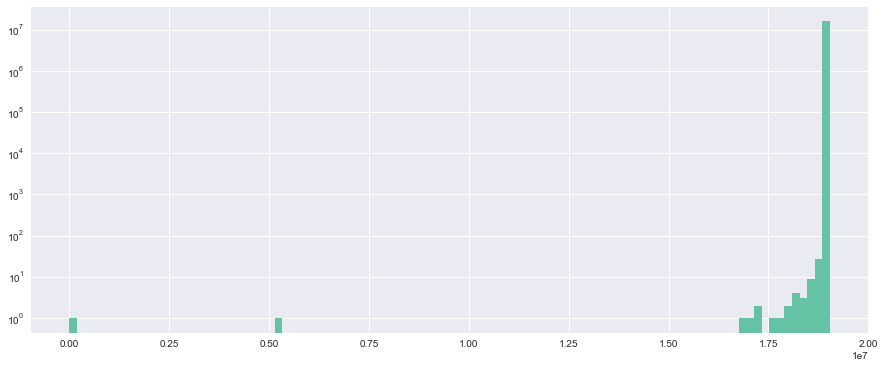

In [131]:
plt.hist(quran_graph.reshape(-1), bins=100, log=True);

In [132]:
graph.sparsity(quran_graph)

6.281367581628672e-08

In [133]:
quran_graph.shape

(3990, 3990)

In [134]:
word_map_used_inv = {i[1]:i[0] for i in words_map.items()}

In [135]:
word_map_used_inv[np.argmin(quran_graph.sum(axis=0))]

'allah'

In [136]:
np.argmin(quran_graph.sum(axis=0))

3764

In [137]:
(quran_graph.sum(axis=0) == 0).sum()

0

In [138]:
word_map_used_inv = {i[1]:i[0] for i in words_map.items()}

In [139]:
def get_adjacent(word, n=10, word_map_used=words_map):
    index = word_map_used[word]
    for i in range(n):
        print(word_map_used_inv[np.argsort(quran_graph[index])[::-1][i]])

In [140]:
word_map_used_inv[0]

'secretly'

# ANALYSIS

In [123]:
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import sparse, stats, spatial
from sklearn import preprocessing, decomposition, model_selection

%matplotlib inline
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))

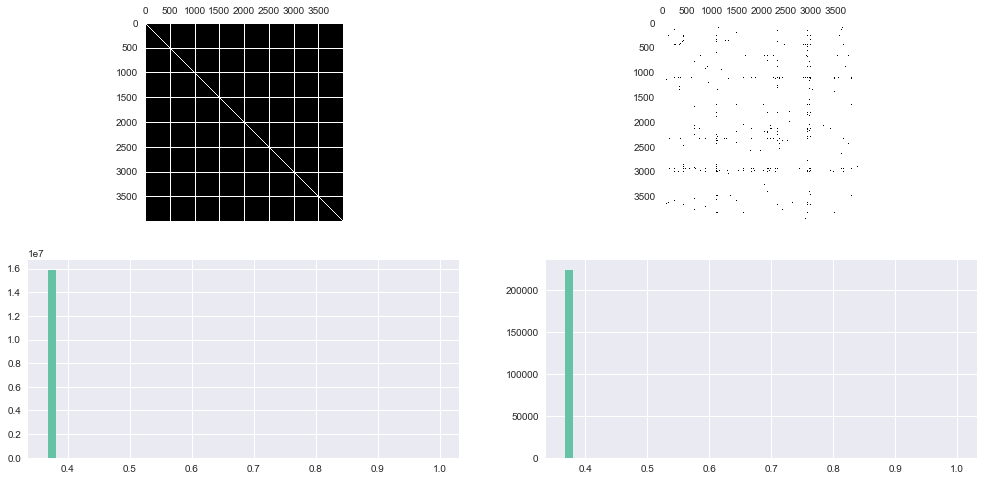

In [168]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:, 0])

NEIGHBORS = 700
weights_sorted = weights.copy()
weights_sorted.sort()
# The threshold element, if a value is below, we will discard it.
weights_threshold = weights_sorted[:,weights.shape[0]-NEIGHBORS]
weights_sparse = weights * (weights.T > weights_threshold).T
# weights_sparse = weights * (np.argsort(weights) >= (weights.shape[0]-NEIGHBORS))

weights_sparse = weights_sparse - (weights_sparse - weights_sparse.T)
weights_sparse_sym_tool = weights_sparse - weights_sparse.T
weights_sparse = weights_sparse - weights_sparse_sym_tool*(weights_sparse_sym_tool < 0)

plot(weights_sparse, axes[:, 1])

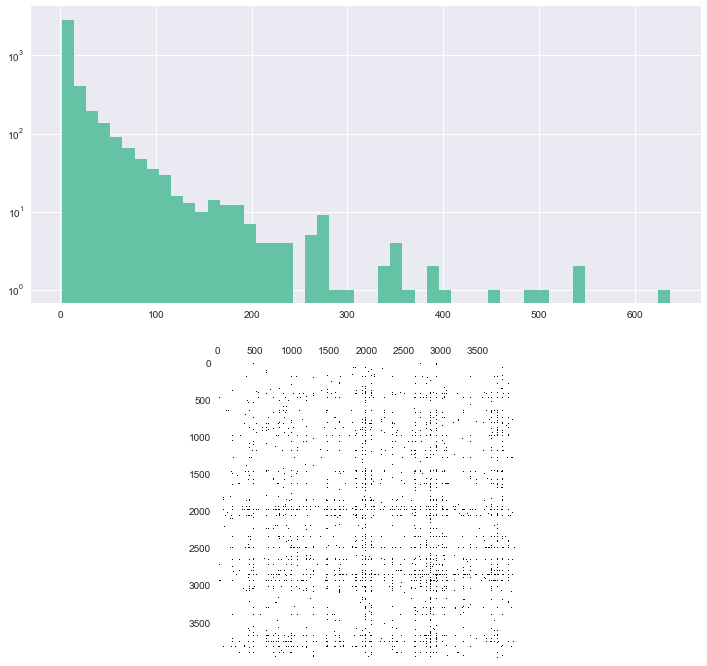

In [169]:
degrees = np.sum(weights_sparse, axis=1)
fix, ax = plt.subplots(2, 1, figsize=(12, 12))

ax[0].hist(degrees, bins=50, log=True)
ax[1].spy(weights_sparse)

In [170]:
D = np.diag(degrees)
W = weights
L = D - W

In [171]:
inv_sqrt_D = np.diag(1 / np.diag(D**(0.5)))

In [172]:
normalized_laplacian = inv_sqrt_D @ L @ inv_sqrt_D

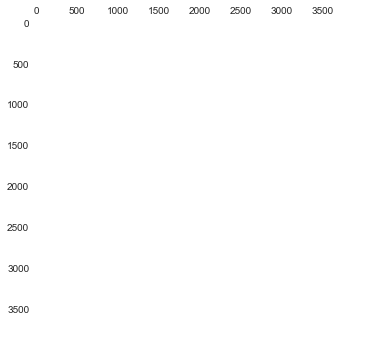

In [173]:
plt.spy(normalized_laplacian);

In [174]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(normalized_laplacian, k=10, which='SM') # which='SA' gives us similar results

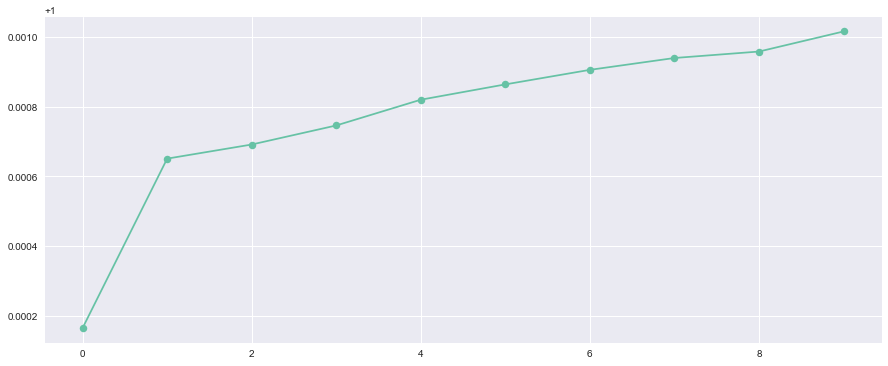

In [175]:
plt.plot(eigenvalues, '.-', markersize=15);

In [150]:
G = nx.from_numpy_matrix(L)
gc = max(nx.connected_component_subgraphs(G), key=len)

In [151]:
assert len(gc.nodes()) == W.shape[0], "GCC should contain all nodes"

# VIZ

In [152]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [153]:
init_notebook_mode(connected=True)
print(__version__)

2.2.3


In [176]:
trace = go.Scatter3d(
    x=eigenvectors[:, 1],
    y=eigenvectors[:, 2],
    z=eigenvectors[:, 3],
    name='a',
    mode='markers',
    marker=dict(
        size=12,
        color='b',
        #colorscale='Viridis',
        #opacity=0.8,
        line=dict(
            width=2,
            color='black'
        )
    )
)

In [177]:
layout = go.Layout(
    hovermode= 'closest',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

In [178]:
data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig)